# elitism

In [1]:
from IPython import get_ipython

In [ ]:
if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scanpy as sc
import latenta as la
import jax
import jax.numpy as jnp
import optax
import tqdm.auto as tqdm
import scipy
import random
import re
import dill as pickle
import sklearn.decomposition
import os
import eyck
from general_functions.model_generation_functions import *
from general_functions.model_visualization_functions import *

/srv/data/robinve/miniconda3/envs/latenta/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
with open("elitism/scores.pkl", "rb") as f:
    scores = pickle.load(f)
with open("elitism/dictionary.pkl", "rb") as f:
    elitism_model_dict_per_generation = pickle.load(f)

In [19]:
scores["lik_penalty_ratio"] = scores["lik"] / scores["penalty"]

In [21]:
scores["initialisation"] = scores["initialisation"].replace("semi_biased_initialization", "PCA_initialized")

In [22]:
for element in scores['initialisation'].unique():
    print(element)

unbiased_initialization
PCA_initialized


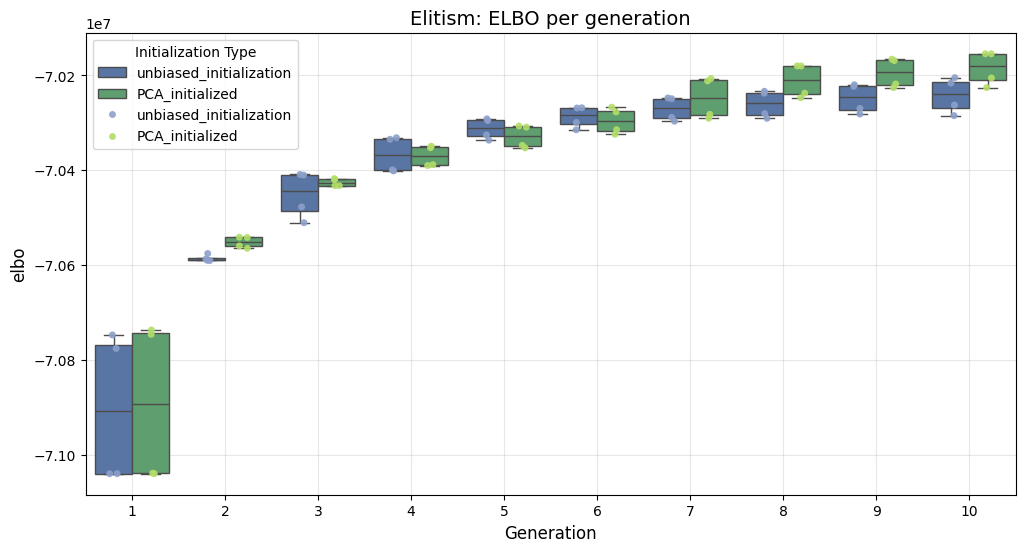

In [23]:
boxplot_per_generation(scores, "elbo")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_4080333/2969869007.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")  # Purple-to-yellow colormap


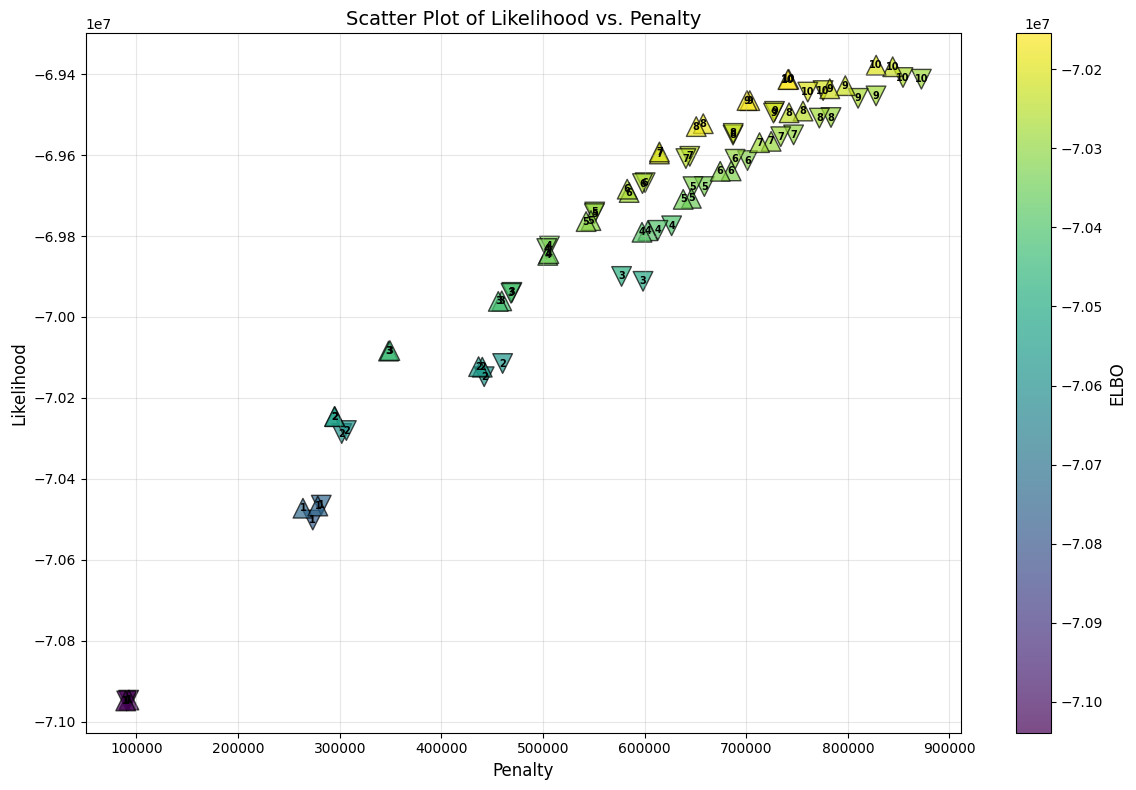

In [24]:
all_scores = scores
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Add a new column for grouping
def group_model(row):
    return str(row["number_of_effects"])  # Ensure group numbers are strings for annotation

all_scores["group"] = all_scores.apply(group_model, axis=1)

# Normalize ELBO for the color mapping
norm = mcolors.Normalize(vmin=all_scores["elbo"].min(), vmax=all_scores["elbo"].max())
cmap = cm.get_cmap("viridis")  # Purple-to-yellow colormap

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

markers = {"unbiased_initialization":"v", "PCA_initialized": "^"}

for group,marker in markers.items():
    group_data = all_scores[all_scores["initialisation"] == group]
    # Scatter plot with group numbers as "markers"
    scatter = ax.scatter(
        x=group_data["penalty"],
        y=group_data["lik"],
        c=group_data["elbo"],
        cmap=cmap,
        norm=norm,
        edgecolor="black",
        alpha=0.7,
        marker=marker,  # Define specific markers
        s=200  # Adjust size of markers
    )

# Annotate each point with its group number
for _, row in all_scores.iterrows():
    
        
    ax.text(
        x=row["penalty"],
        y=row["lik"],
        s=row["group"],  # Use group number as text
        fontsize=7,
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
        alpha = 1
    )

# Add a colorbar for the ELBO
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("ELBO", fontsize=12)

# Add labels and title
ax.set_xlabel("Penalty", fontsize=12)
ax.set_ylabel("Likelihood", fontsize=12)
ax.set_title("Scatter Plot of Likelihood vs. Penalty", fontsize=14)

# Add grid and adjust layout
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [25]:
best_model_per_generation = []
for generation in range(10):
    generation_scores = scores[scores["generation"] == generation]
    unbiased_scores = generation_scores[generation_scores["initialisation"] == "unbiased_initialization"]
    unbiased_scores = unbiased_scores.reset_index(drop=True)
    unbiased_best_model_name = unbiased_scores.iloc[unbiased_scores["elbo"].idxmax()]["model_name"]
    unbiased_best_model_generation = unbiased_scores.iloc[unbiased_scores["elbo"].idxmax()]["generation"]

    u_best_model = elitism_model_dict_per_generation["unbiased_initialization"][unbiased_best_model_generation][unbiased_best_model_name][0]
    best_model_per_generation.append(u_best_model)

In [26]:
unbiased_adata_list = []
for model in best_model_per_generation:
    adata_u_best_model = data_adata_converter(model)
    unbiased_adata_list.append(adata_u_best_model)

In [ ]:
n_cols = len(unbiased_adata_list)
n_rows = 5

fig, axes = plt.subplots(n_rows, n_cols , figsize=(5 * n_cols + 1, 5 * n_rows))  # Extra column for text

for i, adata in enumerate(unbiased_adata_list):
    
    color_columns1 = adata.obs.columns.tolist()[:min(5,len(adata.obs.columns))]
    for j, column in enumerate(color_columns1):
        ax1 = axes[j, i]
        sc.pl.umap(adata, color=column,ax=ax1, show=False)
    for remaining in range(len(color_columns1), n_rows):
        ax1 = axes[remaining, i]
        ax1.axis("off")
plt.tight_layout()
plt.show()

In [28]:
best_model_per_generation = []
for generation in range(10):
    generation_scores = scores[scores["generation"] == generation]
    biased_scores = generation_scores[generation_scores["initialisation"] == "PCA_initialized"]
    biased_scores = biased_scores.reset_index(drop=True)
    biased_best_model_name = biased_scores.iloc[biased_scores["elbo"].idxmax()]["model_name"]
    biased_best_model_generation = biased_scores.iloc[biased_scores["elbo"].idxmax()]["generation"]

    b_best_model = elitism_model_dict_per_generation["semi_biased_initialization"][biased_best_model_generation][biased_best_model_name][0]
    best_model_per_generation.append(b_best_model)

In [29]:
biased_adata_list = []
for model in best_model_per_generation:
    adata_b_best_model = data_adata_converter(model)
    biased_adata_list.append(adata_b_best_model)

In [ ]:
n_cols = len(biased_adata_list)
n_rows = 5

fig, axes = plt.subplots(n_rows, n_cols , figsize=(5 * n_cols + 1, 5 * n_rows))  # Extra column for text

for i, adata in enumerate(biased_adata_list):
    
    color_columns1 = adata.obs.columns.tolist()[:min(5,len(adata.obs.columns))]
    for j, column in enumerate(color_columns1):
        ax1 = axes[4-j, i]
        sc.pl.umap(adata, color=column,ax=ax1, show=False)
    for remaining in range(len(color_columns1), n_rows):
        ax1 = axes[4-remaining, i]
        ax1.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
compare_adata_obs(unbiased_adata_list[4], biased_adata_list[4],name1="unbiased", name2="PCA-initialized", threshold=0.5, compact=True)

## elitism best model from scratch

In [ ]:
scores, model_dict = latenta_processes_basic(base_model, optimizer, "base_model", "base_model_0_0", 1000)

In [36]:
base_model = model_dict["base_model_0_0"][0]

In [ ]:
[column.split('.')[0][:-1] for column in biased_adata_list[9].obs.columns]

In [ ]:
effects = [column.split('.')[0][:-1] for column in biased_adata_list[9].obs.columns]
model = base_model
scores = pd.DataFrame()
model_dict = {}
for i in range(10):
    for j,effect in enumerate(effects):
        placeholder[0] = i
        x = initialization_func2()
        model = change_model_amortized(model,x, effect,f'{effect}_{j}')
    architecture_name = get_architecture_name(model)
    new_scores, new_model_dict = latenta_processes_basic(model, optimizer, architecture_name, f'{architecture_name}_{i}', 3000)
    scores = pd.concat([scores, new_scores], axis=0, ignore_index=True)
    model_dict.update(new_model_dict)

In [66]:
best_model_per_generation[9]

transcriptome: p ↦ Observation [cell (10433), gene (22731)] ~ NegativeBinomial2

In [67]:
with open("elitism/scores.pkl", "rb") as f:
    elitism_scores = pickle.load(f)

In [ ]:
best_row = elitism_scores.iloc[elitism_scores["elbo"].idxmax()]

In [76]:
best_row["model_name"] = "original_model"

/tmp/ipykernel_4019914/1605145405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_row["model_name"] = "original_model"


In [87]:
df = pd.concat([scores, pd.DataFrame([best_row])], ignore_index=True)
df = df.drop(columns=['index',	'generation',	'initialisation',	'relative_elbo',	'relative_lik',	'relative_penalty'])

In [88]:
df = relative_values_dataframe(df)

In [94]:
df.style.bar(subset=['relative_elbo','relative_lik',	'relative_penalty'], cmap="Reds")

,elbo,elbo_std,lik,penalty,architecture,model_name,relative_elbo,relative_lik,relative_penalty
0,-70207312.000000,0.000000,-69453024.000000,754288.000000,SplSigCirSigSigSigSigLinSigSig,SplSigCirSigSigSigSigLinSigSig_0,111344.000000,110672.000000,18112.000000
1,-70171648.000000,0.000000,-69435472.000000,736176.000000,SplSigCirSigSigSigSigLinSigSig,SplSigCirSigSigSigSigLinSigSig_1,147008.000000,128224.000000,0.000000
2,-70214440.000000,0.000000,-69468656.000000,745784.000000,SplSigCirSigSigSigSigLinSigSig,SplSigCirSigSigSigSigLinSigSig_2,104216.000000,95040.000000,9608.000000
3,-70208024.000000,0.000000,-69468880.000000,739144.000000,SplSigCirSigSigSigSigLinSigSig,SplSigCirSigSigSigSigLinSigSig_3,110632.000000,94816.000000,2968.000000
4,-70269080.000000,0.000000,-69514688.000000,754392.000000,SplSigCirSigSigSigSigLinSigSig,SplSigCirSigSigSigSigLinSigSig_4,49576.000000,49008.000000,18216.000000
5,-70255272.000000,0.000000,-69508848.000000,746424.000000,SplSigCirSigSigSigSigLinSigSig,SplSigCirSigSigSigSigLinSigSig_5,63384.000000,54848.000000,10248.000000
6,-70271960.000000,0.000000,-69521416.000000,750544.000000,SplSigCirSigSigSigSigLinSigSig,SplSigCirSigSigSigSigLinSigSig_6,46696.000000,42280.000000,14368.000000
7,-70283032.000000,0.000000,-69526280.000000,756752.000000,SplSigCirSigSigSigSigLinSigSig,SplSigCirSigSigSigSigLinSigSig_7,35624.000000,37416.000000,20576.000000
8,-70318656.000000,0.000000,-69563696.000000,754960.000000,SplSigCirSigSigSigSigLinSigSig,SplSigCirSigSigSigSigLinSigSig_8,0.000000,0.000000,18784.000000
9,-70292992.000000,0.000000,-69539680.000000,753312.000000,SplSigCirSigSigSigSigLinSigSig,SplSigCirSigSigSigSigLinSigSig_9,25664.000000,24016.000000,17136.000000


In [ ]:
best_model_name = df.iloc[new_scores["elbo"].idxmax()]["model_name"]

In [ ]:

replicate_model = model_dict[best_model_name][0]
adata_replicate = data_adata_converter(replicate_model)

In [97]:
original_adata = biased_adata_list[9]

In [ ]:
n_cols = 10
n_rows = 2
adatas = [original_adata, adata_replicate]
fig, axes = plt.subplots(n_rows, n_cols , figsize=(5 * n_cols + 1, 5 * n_rows))  # Extra column for text
row_title = ["original models", "replicate models"]
for i in range(2):
    fig.text(
        x=-0.06,  # Position slightly to the right of the plots
        y=1 - (i + 0.5) / 2,  # Middle of the row
        s=row_title[i],
        ha='left',
        va='center',
        fontsize=14,
        fontweight='bold',
        transform=fig.transFigure,
    )
for i, adata in enumerate(adatas):
    color_columns1 = adata.obs.columns.tolist()
    for j, column in enumerate(color_columns1):
        ax1 = axes[i, j]
        sc.pl.umap(adata, color=column,ax=ax1, show=False)
plt.tight_layout()
plt.show()

In [ ]:
compare_adata_obs(original_adata, adata_replicate,name1="original_adata", name2="adata_replicate", threshold=0.5, compact=True)

In [ ]:
replicate_model_losses = model_dict[best_model_name][1]
b_best_model_losses = elitism_model_dict_per_generation["semi_biased_initialization"][biased_best_model_generation][biased_best_model_name][1]
plot_multiple_losses_with_completion([replicate_model_losses, b_best_model_losses],loss_names=['replicate model', "original model"], tail_size=2000, window_size=100)

In [113]:
_,model_dict1 = latenta_processes_basic(replicate_model, optimizer, "best_replicate", "best_replicate_0", 3000)

100%|██████████| 3000/3000 [04:05<00:00, 12.22it/s]


In [120]:
_

,elbo,elbo_std,lik,penalty,architecture,model_name
0,-70145536.0,0.0,-69406448.0,739088.0,best_replicate,best_replicate_0


In [121]:
df1 = pd.concat([_, pd.DataFrame([best_row])], ignore_index=True)
df1 = df1.drop(columns=['index',	'generation',	'initialisation',	'relative_elbo',	'relative_lik',	'relative_penalty'])
df1 = relative_values_dataframe(df1)
df1.style.bar(subset=['relative_elbo','relative_lik',	'relative_penalty'], cmap="Reds")

,elbo,elbo_std,lik,penalty,architecture,model_name,relative_elbo,relative_lik,relative_penalty
0,-70145536.000000,0.000000,-69406448.000000,739088.000000,best_replicate,best_replicate_0,8776.000000,6840.000000,0.000000
1,-70154312.000000,0.000000,-69413288.000000,741024.000000,SplSigCirSigSigSigSigLinSigSig,original_model,0.000000,0.000000,1936.000000


In [117]:
replicate_model1 = model_dict1["best_replicate_0"][0]

In [118]:
adata_replicate1 = data_adata_converter(replicate_model1)

In [ ]:
compare_adata_obs(original_adata, adata_replicate1,name1="original_adata", name2="adata_replicate1", threshold=0.5, compact=True)

In [ ]:
n_cols = 10
n_rows = 3
adatas = [original_adata,adata_replicate, adata_replicate1]
fig, axes = plt.subplots(n_rows, n_cols , figsize=(5 * n_cols + 1, 5 * n_rows))  # Extra column for text
row_title = ["original model", "replicate model","replicate model+"]
for i in range(3):
    fig.text(
        x=-0.06,  # Position slightly to the right of the plots
        y=1 - (i + 0.5) / 3,  # Middle of the row
        s=row_title[i],
        ha='left',
        va='center',
        fontsize=14,
        fontweight='bold',
        transform=fig.transFigure,
    )
for i, adata in enumerate(adatas):
    color_columns1 = adata.obs.columns.tolist()
    for j, column in enumerate(color_columns1):
        ax1 = axes[i, j]
        sc.pl.umap(adata, color=column,ax=ax1, show=False)
plt.tight_layout()
plt.show()

In [126]:
def compare_adata_obs_dataframe(
    adata1, adata2, name1="Adata1", name2="Adata2",
    compact=False, threshold=0.7
):
    """
    Compare all columns in adata1.obs with all columns in adata2.obs using scatterplots.
    Returns a DataFrame with correlations.
    """
    # Get the columns from both adata1.obs and adata2.obs
    columns_adata1 = adata1.obs.columns
    columns_adata2 = adata2.obs.columns

    # Store pairs of columns to plot
    plot_data = []

    for feature1 in columns_adata1:
        for feature2 in columns_adata2:
            # Skip non-numeric columns
            if adata1.obs[feature1].dtype.kind not in 'biufc' or adata2.obs[feature2].dtype.kind not in 'biufc':
                continue

            # Calculate correlation
            corr = adata1.obs[feature1].corr(adata2.obs[feature2])
            
            # Store plot data
            if not compact or abs(corr) >= threshold:
                plot_data.append({
                    'feature1': feature1,
                    'feature2': feature2,
                    'correlation': corr,
                    'name1': name1,
                    'name2': name2
                })

    # Return the correlation data
    return pd.DataFrame(plot_data)


In [153]:
run1_data = compare_adata_obs_dataframe(original_adata, adata_replicate, name1="Run1_Adata1", name2="Run1_Adata2",threshold=0.5, compact=True)
run2_data = compare_adata_obs_dataframe(original_adata, adata_replicate1, name1="Run2_Adata1", name2="Run2_Adata2",threshold=0.5, compact=True)

In [154]:
combined_data = pd.concat([run1_data.assign(run="Run 1"), run2_data.assign(run="Run 2")], ignore_index=True)

In [170]:
run1 = combined_data[combined_data["run"] == "Run 1"]["correlation"]
run2 = combined_data[combined_data["run"] == "Run 2"]["correlation"]

In [183]:
run2

9     0.988472
10    0.911166
11    0.720565
12    0.916775
13    0.942143
14    0.700618
15   -0.706027
16    0.751499
17    0.605813
Name: correlation, dtype: float64

In [180]:
run_difference = run2.values - run1.values

In [181]:
run_difference

array([ 0.00070306,  0.02063656, -0.00113651,  0.0054773 ,  0.00265143,
        0.01537684,  0.01049394,  0.14370921,  0.00895351])

In [ ]:
replicate_model_losses = model_dict['SplSigCirSigSigSigSigLinSigSig_1'][1]
replicate_model1_losses = model_dict1["best_replicate_0"][1]
b_best_model_losses = elitism_model_dict_per_generation["semi_biased_initialization"][biased_best_model_generation][biased_best_model_name][1]
plot_multiple_losses_with_completion([replicate_model_losses, b_best_model_losses,replicate_model1_losses],loss_names=['replicate model', "original model","replicate_model+"], tail_size=2000, window_size=100, completion=False)